In [1]:
import matplotlib.pylab as plt
import numpy as np

# Ray tracing Vectorized

* $A$: beam origin
* $B$: beam intersection with sample plane
* $C$: diffracted beam intersection with detector plane
* $D$: incident beam intersection with detector plane (direct beam)


In [2]:
def normed(array_of_vector):
    ''' return the array of normed vector (vector along the last dim)
        i.e. a (nbre_vector, n_dim) array'''
    array_of_vector = np.asarray(array_of_vector)
    norm = np.linalg.norm(array_of_vector, axis=-1, keepdims=True)
    return  np.divide(array_of_vector, norm, where=norm>0)

# test
assert np.allclose(normed(np.array((2, 0, 0))),
                   np.array((1, 0, 0)))
assert np.allclose(normed(np.array([(0, 2, 0), (0, -3, 0), (0, 0, 0), (-1, 0, 0)])),
                   np.array([(0, 1, 0), (0, -1, 0), (0, 0, 0), (-1, 0, 0)]))

In [3]:
def plane_intersection(A, u, plane_center, plane_normal):
    # Intersection of incident beams with sample plane:
    A = np.asarray(A, dtype=np.float64)
    u = np.asarray(u, dtype=np.float64)


    AP_dot_n = np.inner((A - plane_center), plane_normal)
    u_dot_n = np.inner(u, plane_normal)

    t = - np.divide(AP_dot_n, u_dot_n,
                    where=np.logical_not(np.isclose(u_dot_n, 0)))
    t[t<0] = np.NaN
    B = A + u*t[:, np.newaxis]
    return B

# test
A = np.array([(1, 0, 0), (2, 1, 0), (1, 0, 1), (1, 0, 0),
              (-1, 0, 0), (-1, 0, 0), (2, 0, 1), (2, 2, -2)])
u = np.array([(-1, 0, 0), (-1, 0, 0), (-1, 0, 0), (-1, 0, -1),
              (-1, 0, 0), (1, 0, 1), (1, 0, 0), (1, 0, 0)])

plane_center = np.array((0, 0, 0))
plane_normal = np.array((1, 0, 1))

assert np.allclose(plane_intersection(A, u, plane_center, plane_normal),
                   np.array([[ 0. ,  0. ,  0. ],
                           [ 0. ,  1. ,  0. ],
                           [-1. ,  0. ,  1. ],
                           [ 0.5,  0. , -0.5],
                           [ np.nan,  np.nan,  np.nan],
                           [-0.5,  0. ,  0.5],
                           [ np.nan,  np.nan,  np.nan],
                           [ 2. ,  2. , -2. ]]), equal_nan=True)

In [203]:
# inputs
deuxtheta = np.pi/4
rayon_gonio = 320 # mm

# Incident beam
N = 2210
Ax = np.ones((N, 1)) * rayon_gonio
Ay = (np.random.rand(N, 1)-0.5) * 10
Az = (np.random.rand(N, 1)-0.5) * 0.5 # mm


u_incident_x = -np.ones((N, 1))
u_incident_y = np.zeros((N, 1))
u_incident_z = np.zeros((N, 1))

A = np.hstack([Ax, Ay, Az])
u_incident = normed( np.hstack([u_incident_x, u_incident_y, u_incident_z]) )

# Define detector
detector_position  = np.array((-rayon_gonio*np.cos(deuxtheta),
                              0,
                              +rayon_gonio*np.sin(deuxtheta)))
detector_normal = normed(np.array((+np.cos(deuxtheta),
                                  0,
                                  -np.sin(deuxtheta))))
detector_vertical = normed(np.array((0, 1, 0)))
detector_horizontal = np.cross(detector_normal, detector_vertical)

# Define sample
omega = deuxtheta/2
sample_position  = normed((0, 0, 0))
sample_normal = normed((+np.sin(omega), 0, +np.cos(omega)))

In [204]:
# Intersection of incident beams with sample plane:
B = plane_intersection(A, u_incident, sample_position, sample_normal)

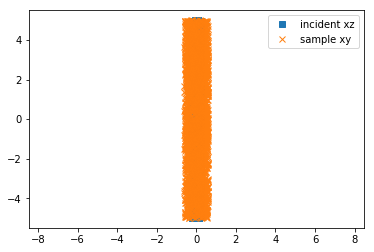

In [205]:
plt.plot(A[:, 2], A[:, 1], 's', label='incident xz')
plt.plot(B[:, 0], B[:, 1], 'x', label='sample xy')
plt.axis('equal'); plt.legend();

In [206]:
# Diffracted cone

# detector base vector - relative to the cone axis
v_plane = np.cross(detector_normal, u_incident) # vertical
norm_v = np.linalg.norm(v_plane, axis=-1, keepdims=False)
v_plane[np.isclose(norm_v, 0)] = detector_vertical
v_plane = normed(v_plane)

u_plane = np.cross(detector_normal, v_plane)

# faisceau direct dans le plan du detecteur
D = plane_intersection(A, u_incident,
                       detector_position, detector_normal)

# Inclinaison angle
cos_beta = np.abs(np.dot(u_incident, detector_normal))[:, np.newaxis]
sin_beta = np.linalg.norm( np.cross(u_incident, detector_normal),
                          axis=-1 )[:, np.newaxis]

Ellipse radius in the detector plane:

$$rho(\Gamma) = z_0 \, \frac{tan_{\alpha} \left(tan_{\alpha} \sin{\left(\beta \right)} \cos{\left(\Gamma \right)} - \sqrt{\sin^{2}{\left(\Gamma \right)} + \cos^{2}{\left(\Gamma \right)} \cos^{2}{\left(\beta \right)}}\right)}{- tan_{\alpha}^{2} \sin^{2}{\left(\beta \right)} \cos^{2}{\left(\Gamma \right)} + \sin^{2}{\left(\Gamma \right)} + \cos^{2}{\left(\Gamma \right)} \cos^{2}{\left(\beta \right)}}$$


In [207]:
gamma_range = 5 *np.pi/180 # rad
gamma_offset = 0
gamma = np.linspace(-gamma_range+gamma_offset,
                    +gamma_range+gamma_offset, 30)  # no Gamma=0... 
cos_Gamma = np.cos(gamma)
sin_Gamma = np.sin(gamma)
tan_alpha = np.tan( deuxtheta )#20*np.pi/180 )  # tan theta

In [208]:
# Distance du plan par rapport au sommet du cone, sur  l'axe du cone
z0 = np.linalg.norm(D - B, axis=-1, keepdims=True)

In [209]:
racine = np.sqrt(cos_beta**2 * cos_Gamma**2 + sin_Gamma**2)
up = tan_alpha*sin_beta*cos_Gamma - racine
below = -tan_alpha**2 * sin_beta**2 * cos_Gamma**2 + sin_Gamma**2 + cos_Gamma**2*cos_beta**2
rho = -np.divide(tan_alpha * z0 * up, below, where=np.abs(below)>0)  # not true for gamma=0

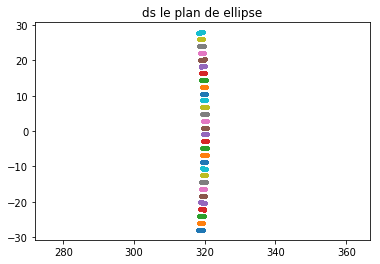

In [210]:
plt.plot(rho*cos_Gamma, rho*sin_Gamma, '.');
plt.axis('equal'); plt.title('ds le plan de ellipse');

In [211]:
# Diffracted point on the detecteur plane, using absolute coordiantes
C_from_axis = (rho*cos_Gamma)[:, :, np.newaxis] * u_plane[:, np.newaxis, :] \
             +(rho*sin_Gamma)[:, :, np.newaxis] * v_plane[:, np.newaxis, :]

C = C_from_axis + D[:, np.newaxis, :]
#C = C.reshape((-1, 3))

In [221]:
u_diff = normed( (C - B[:, np.newaxis, :]).reshape((-1, 3)) ) # Direction of the diffracted beams

In [223]:
u_diff_XZ = np.multiply(u_diff, np.array((1, 0, 1))) # projection on the XZ plane

In [244]:
delta_deuxtheta_diffracted = np.arctan2(u_diff[:, 2], -u_diff[:, 0]) - deuxtheta

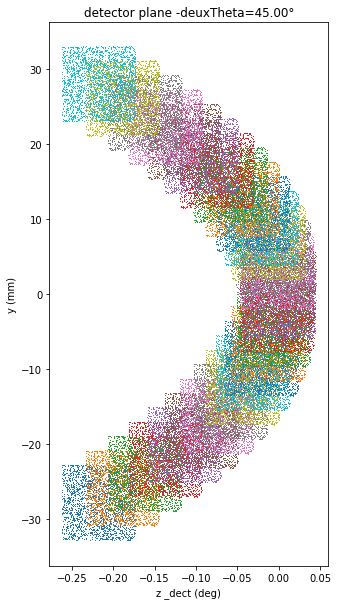

In [245]:
# Projection back in the detecteur plane
uy_direct_beam = np.dot(D, detector_vertical)
uz_direct_beam = np.dot(D, detector_horizontal)

uz = np.dot(C , detector_horizontal)
uy = np.dot(C , detector_vertical)

#plt.plot(A[:, 2], A[:, 1], 's')
#plt.plot(D[:, 2], D[:, 1], 'x')
plt.figure(figsize=(5, 10))
plt.plot(uz/rayon_gonio *180/np.pi, uy, ',');
#plt.plot(uz_direct_beam, uy_direct_beam, 'x', alpha=0.5);
#plt.axis('equal');
plt.title('detector plane -deuxTheta=%.2f°' % (180/np.pi*deuxtheta))
plt.xlabel('z _dect (deg)'); plt.ylabel('y (mm)');

In [250]:
detector_height = 30 # mm
acceptance_deg = 1/4 # degree
detector_width = acceptance_deg *np.pi/180 * rayon_gonio

In [251]:
detector_width

1.3962634015954636

In [253]:
vertical_clip = np.logical_and(uy < detector_height/2, uy > -detector_height/2)
horizontal_clip = np.logical_and(uz < detector_width/2, uz > -detector_width/2)
# Acceptance clip (on delta_deuxtheta)

In [254]:
total_clip = np.logical_and(vertical_clip, horizontal_clip)

In [257]:
total_clip.sum()

34290

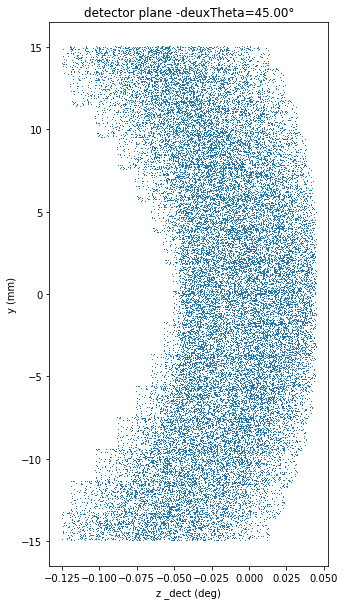

In [255]:
plt.figure(figsize=(5, 10))
plt.plot(uz[total_clip]/rayon_gonio *180/np.pi, uy[total_clip], ',');
#plt.plot(uz_direct_beam, uy_direct_beam, 'x', alpha=0.5);
#plt.axis('equal');
plt.title('detector plane -deuxTheta=%.2f°' % (180/np.pi*deuxtheta))
plt.xlabel('z _dect (deg)'); plt.ylabel('y (mm)');

### Improvements:
* equation for cone intersection with cylinder, instead of plane
